## Visualizing Neuron Activation Map

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from torch.autograd import Variable

In [2]:
MODEL_PATH = '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [3]:
n_classes = 5
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}

params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


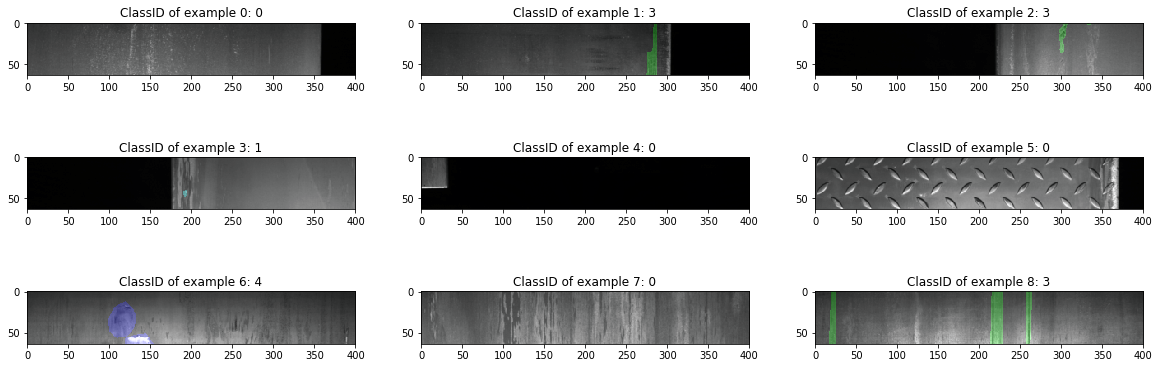

In [4]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)

fig, ax = plt.subplots(3, 3, figsize=(20, 7))
start = 0
for i in range(start, start+9):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    if y_val[i] > 0:
        img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]-1]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

In [5]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [6]:
y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), 
                                                  f1_score(y_true, y_pred, average='macro')))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:24<00:00, 50.11it/s]


Accuracy: 0.9213	F1 Score: 0.8511


### Visualize Neuron Maps

In [7]:
modules = [
           list(net.children())[0][0], 
           list(net.children())[0][3].squeeze, list(net.children())[0][3].expand1x1, list(net.children())[0][3].expand3x3,
           list(net.children())[0][4].squeeze, list(net.children())[0][4].expand1x1, list(net.children())[0][4].expand3x3,
           list(net.children())[0][6].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][6].expand3x3,
           list(net.children())[0][7].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][7].expand3x3,
           list(net.children())[0][9].squeeze, list(net.children())[0][9].expand1x1, list(net.children())[0][9].expand3x3,
           list(net.children())[1][1]
          ]

mean = X_val.mean()
std = X_val.std()
project = (float(X_val.mean()-3*X_val.std()), float(X_val.mean()+3*X_val.std()))

In [ ]:
dim = (64, 400)
layer = 12
neuron = 36

detector = c_explainers.Detector(model=net, lr=10, loss_type=1)
#inp = torch.randn(1, 3, dim[0], dim[1]).to(device)*std*1.2 + mean
inp = X_val[0][:, :, :].unsqueeze(0).to(device)
loss, out, x = detector.detect(dim=dim, 
                               module=modules[layer], 
                               neuron=neuron,
                               max_epoch=200,
                               max_activation=500, 
                               warm_start = inp,
                               project = (float(mean-3*std), float(mean+3*std)),
                               debug = 0,
                               verbose = 1)
print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
img = np.transpose(x.detach().cpu().numpy().squeeze(0), (1, 2, 0))*params['std'] + params['mean']
ax.imshow(img)
ax.set_title('Neuron {} on layer {}'.format(neuron, layer))
plt.show()

In [ ]:
resize_factor = 1.7
start = (40, 40)
lr = 2
epochs = 50
blur_kernel = (3, 3) 

def resize(tensor, dim, blur_kernel=(1,1)):
    if tensor.shape[0] == 3:
        x = np.transpose(tensor.detach().cpu().numpy(), (1, 2, 0))
    else:
        x = np.transpose(tensor.detach().cpu().squeeze(0).numpy(), (1, 2, 0))
   
    x = cv2.resize(x, dim)
    x = np.transpose(x, (2, 1, 0))
    return torch.tensor(x).unsqueeze(0).to(device)

def blur(x, blur_kernel):
    x = np.transpose(x.numpy(), (1, 2, 0))
    x = np.transpose(cv2.blur(x, blur_kernel), (2, 0, 1))
    return torch.tensor(x).unsqueeze(0)
                 
detector = c_explainers.Detector(model=net, lr=lr, loss_type=1)
#inp = torch.randn(1, 3, dim[0], dim[1]).to(device)*std*1.2 + mean
inp = X_val[0]
for i in range(11):
    dim = (int(start[0]*(resize_factor**i)), int(start[1]*(resize_factor**i)))
    inp = resize(inp, dim)
    loss, out, inp = detector.detect(dim=dim, 
                                   module=modules[layer], 
                                   neuron=neuron,
                                   max_epoch=epochs,
                                   max_activation=1000, 
                                   warm_start = inp,
                                   project = (float(mean-3*std), float(mean+3*std)),
                                   debug = 0,
                                   verbose = 1)
    
    inp = inp.squeeze(0).detach().cpu()
    inp = blur(inp, blur_kernel)

In [ ]:
plt.figure(figsize=(50, 50))
img = np.transpose(inp.squeeze(0).cpu().numpy(), (1, 2, 0))
img = cv2.blur(img, (2, 2))
#img = cv2.resize(img, (400, 64))
plt.imshow(img[:, :])
if blur_kernel == (1, 1):
    plt.title('Neuron {} on Layer {}: resized'.format(neuron, layer))
else:
    plt.title('Neuron {} on Layer {}: resized and blurred'.format(neuron, layer))
plt.show()

### Maximise output

Out: tensor([[  1.8338,  11.9470, -13.9337,  -5.1887,  -3.6149]], device='cuda:0')
Out: tensor([[  9.7837,  -2.0583, -12.0966,   1.0413,  -2.5729]], device='cuda:0')
Out: tensor([[ 21.3034, -18.5075, -12.1188,   6.0864,  -1.3638]], device='cuda:0')
Out: tensor([[ 29.8563, -27.1088, -13.3304,   7.1624,  -1.1735]], device='cuda:0')
Out: tensor([[ 39.4260, -34.6941, -17.6264,   8.2804,  -0.1657]], device='cuda:0')
Out: tensor([[ 49.9282, -41.1404, -26.1346,  10.1728,   1.4651]], device='cuda:0')
Out: tensor([[ 62.0185, -47.3943, -37.7059,  12.6495,   3.5639]], device='cuda:0')
Out: tensor([[ 80.2992, -54.9967, -54.8867,  14.7997,   6.8383]], device='cuda:0')
Out: tensor([[104.8101, -63.8572, -81.2166,  15.2608,  12.9913]], device='cuda:0')
Out: tensor([[ 130.6527,  -74.3645, -108.4794,   15.3437,   19.5559]],
       device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Out: tensor([[  1.8338,  11.9470, -13.9337,  -5.1887,  -3.6149]], device='cuda:0')
Out: tensor([[  0.4091,  18.7131, -17.0286,  -4.3639,  -8.9984]], device='cuda:0')
Out: tensor([[ -0.9625,  22.6181, -18.1052,  -1.1663, -13.5891]], device='cuda:0')
Out: tensor([[ -2.4373,  25.7097, -17.7082,   0.8506, -16.3438]], device='cuda:0')
Out: tensor([[ -3.8102,  30.5121, -18.4193,   1.1157, -17.9401]], device='cuda:0')
Out: tensor([[ -4.1244,  34.5541, -19.8473,  -0.4457, -18.5714]], device='cuda:0')
Out: tensor([[ -4.9565,  38.1726, -20.8429,  -2.6822, -18.4845]], device='cuda:0')
Out: tensor([[ -5.9779,  42.6679, -23.7485,  -4.7537, -17.9657]], device='cuda:0')
Out: tensor([[ -8.5594,  52.1032, -31.8744,  -4.6442, -17.5058]], device='cuda:0')
Out: tensor([[-12.7600,  71.2110, -54.4620,   0.7109, -15.9625]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Out: tensor([[  1.8338,  11.9470, -13.9337,  -5.1887,  -3.6149]], device='cuda:0')
Out: tensor([[ 3.0423,  3.0562,  1.0833, -1.8316, -7.3471]], device='cuda:0')
Out: tensor([[ -1.0781,   5.7170,  12.1737,  -4.1962, -12.4893]], device='cuda:0')
Out: tensor([[ -5.6665,  11.4730,  22.2499, -10.0576, -16.6201]], device='cuda:0')
Out: tensor([[ -9.2762,  14.3790,  31.2438, -15.4528, -18.9915]], device='cuda:0')
Out: tensor([[-11.6441,  15.4306,  39.0568, -20.1684, -20.7354]], device='cuda:0')
Out: tensor([[-13.1244,  14.9160,  45.6199, -23.6700, -21.9132]], device='cuda:0')
Out: tensor([[-13.8142,  13.6429,  50.5004, -25.9334, -22.7891]], device='cuda:0')
Out: tensor([[-13.9226,  11.8880,  54.3937, -27.4754, -23.7105]], device='cuda:0')
Out: tensor([[-13.7372,  10.0235,  57.8974, -28.5720, -24.7367]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Out: tensor([[  1.8338,  11.9470, -13.9337,  -5.1887,  -3.6149]], device='cuda:0')
Out: tensor([[  6.3506,  -1.5832, -12.4241,   2.2484,  -0.5363]], device='cuda:0')
Out: tensor([[  9.1975, -13.3232, -16.5539,  12.8923,   3.1957]], device='cuda:0')
Out: tensor([[  6.7978, -16.3301, -22.4021,  24.1540,   2.8621]], device='cuda:0')
Out: tensor([[  4.0541, -21.0884, -48.4002,  57.7300,   0.1099]], device='cuda:0')
Out: tensor([[  0.6514, -13.1312, -93.0742,  95.8497,  -1.9369]], device='cuda:0')
Out: tensor([[  -2.8791,   -1.3670, -133.2154,  127.0876,   -4.3083]],
       device='cuda:0')
Out: tensor([[  -2.9021,   10.4496, -173.4710,  154.5063,   -6.8192]],
       device='cuda:0')
Out: tensor([[  -1.7818,   18.9744, -211.8082,  180.4396,   -8.0726]],
       device='cuda:0')
Out: tensor([[   2.0151,   24.7105, -253.2269,  206.9998,   -8.1680]],
       device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Out: tensor([[  1.8338,  11.9470, -13.9337,  -5.1887,  -3.6149]], device='cuda:0')
Out: tensor([[  2.3321,  -1.3030, -12.6634,   0.6730,   6.3054]], device='cuda:0')
Out: tensor([[  4.9889, -11.9100, -25.8808,  -0.6702,  23.1024]], device='cuda:0')
Out: tensor([[ 15.4772, -30.7130, -64.1138,  -9.3265,  62.6326]], device='cuda:0')
Out: tensor([[  27.7898,  -52.8218, -106.9536,  -16.6814,  105.6820]],
       device='cuda:0')
Out: tensor([[  41.4740,  -70.9111, -141.2032,  -24.4828,  139.4959]],
       device='cuda:0')
Out: tensor([[  55.6745,  -86.8194, -170.0677,  -31.8559,  167.1436]],
       device='cuda:0')
Out: tensor([[  69.7224, -102.6242, -195.9992,  -38.0887,  191.7098]],
       device='cuda:0')
Out: tensor([[  83.9422, -117.8485, -221.7719,  -44.0808,  215.0721]],
       device='cuda:0')
Out: tensor([[  96.6461, -131.5560, -246.0029,  -49.2999,  236.9515]],
       device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


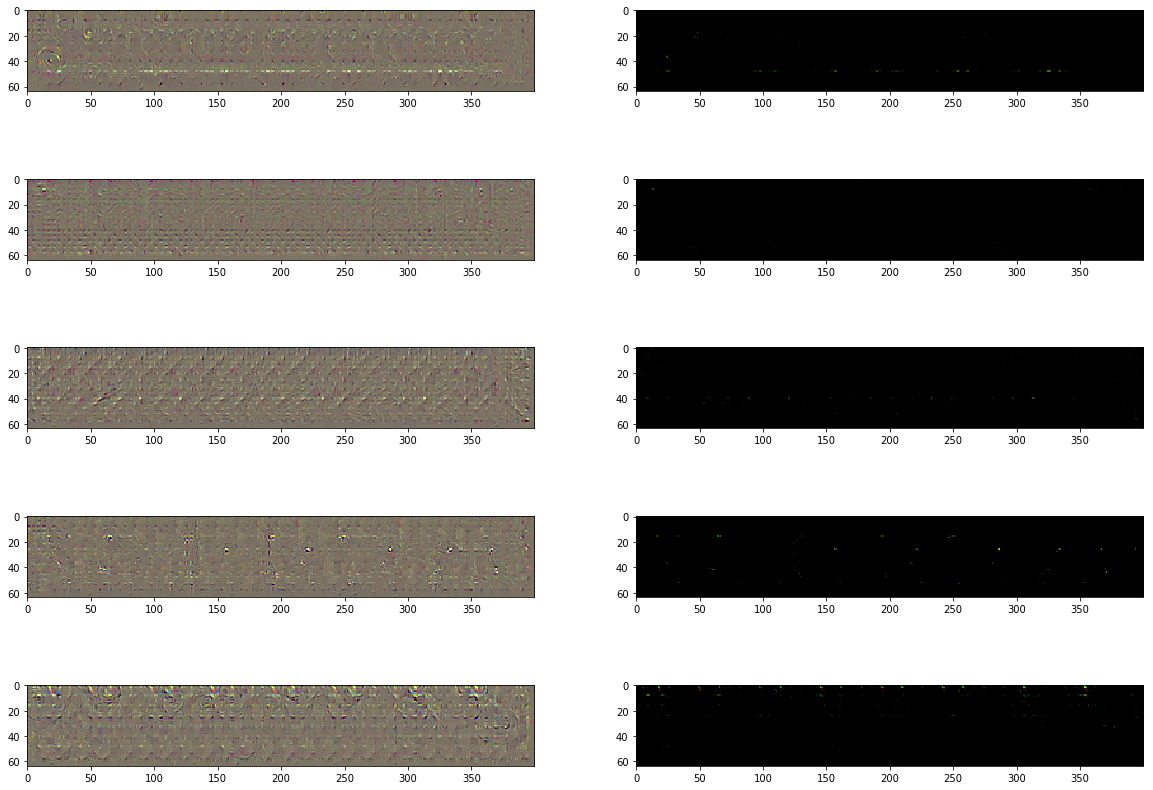

In [37]:
net.eval()
warm_start = False
fig, ax = plt.subplots(5, 2, figsize=(20, 15))
imgs = []
n = 1
for j in range(5):
    if warm_start:
        inp = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    else:
        inp = np.ones((64, 400, 3))*params['std'] + params['mean']
    x = torch.tensor(np.transpose(inp, (2, 0, 1))).unsqueeze(0).to(device).float()
    x_inp = x.clone() + 0.001
    x.requires_grad = True
    for i in range(100):
        out = net(x)
        loss = - (out[0][j] + 20*torch.sum((x-x_inp)**2)**0.5)
        loss.backward()
        if i%10==0:
            #print('Grad:\t', x.grad[0][0])
            #print('Penality term', 0.1*torch.sum((x-x_inp)**2)**0.5)
            #print('Loss', loss)
            print('Out: {}'.format(out.data))
        grad = x.grad.clone()
        #grad[(grad > grad.min()*0.5) & (grad < 0.5*grad.max())] = 0
        x = Variable(x - 0.1*grad,  requires_grad = True)

    # ax[0].imshow(np.transpose(X_val[0].numpy(), (1,2,0))*params['std'] + params['mean'])
    out_img = np.transpose(x.detach().cpu().squeeze(0).numpy(), (1,2,0))*params['std'] + params['mean']
    imgs.append(out_img)
    ax[j, 0].imshow(cv2.blur(out_img, (1, 1)))
    ax[j, 1].imshow(cv2.blur((out_img - inp), (1, 1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0784118133400933


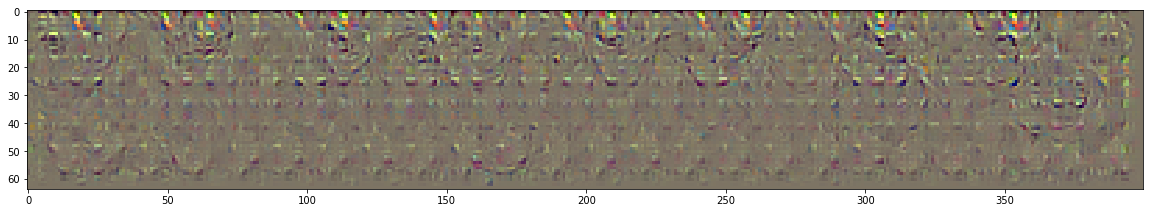

In [46]:
plt.figure(figsize=(20, 6))
inp = imgs[4]
inp = cv2.blur(inp, (1, 1))
print(inp.std())
plt.imshow(inp)#-np.ones((64, 400, 3))*params['std'] + params['mean'])
plt.show()

### Check binary features extractor

In [124]:
BINARY_MODEL_PATH = '../model/OfficialBinaryModels/AugmentedSqueezeReduced10.pth'
### 4.1 Load architecture
binary_net = models.squeezenet1_1(pretrained=True)
binary_net.features = binary_net.features[:10]
binary_net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
binary_net.classifier = nn.Sequential(*binary_net.classifier, nn.Flatten(), nn.Linear(1000, 2))#, nn.Softmax(dim=1))
binary_net = binary_net.to(device)
binary_net.load_state_dict(torch.load(BINARY_MODEL_PATH))

<All keys matched successfully>

In [125]:
new_net = net
accs, f1s = [], []

In [126]:
new_net.features[0] = binary_net.features[0]
y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = new_net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
accs.append(accuracy_score(y_true, y_pred))
f1s.append(f1_score(y_true, y_pred, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:15<00:00, 76.84it/s]


In [127]:
indexes = [3, 4, 6, 7, 9]
for ind in indexes:
    new_net.features[ind] = binary_net.features[ind]
    y_pred, y_true, y_score = [], [], torch.Tensor([])
    batch_size = 2

    with torch.no_grad():
        net.eval()
        for n in tqdm(range(X_val.shape[0]//batch_size)):
            X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
            out = new_net(X)
            probs = out.detach().cpu()
            probs = nn.Softmax(dim=1)(out).detach().cpu()

            y_score = torch.cat([y_score, probs])
            y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
            y_true = np.concatenate([y_true, y.cpu().numpy()])

    y_score = y_score.numpy()
    accs.append(accuracy_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:15<00:00, 76.52it/s]


In [128]:
new_net.classifier[1] = binary_net.classifier[1]
y_pred, y_true, y_score = [], [], torch.Tensor([])

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = new_net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
accs.append(accuracy_score(y_true, y_pred))
f1s.append(f1_score(y_true, y_pred, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:16<00:00, 75.87it/s]


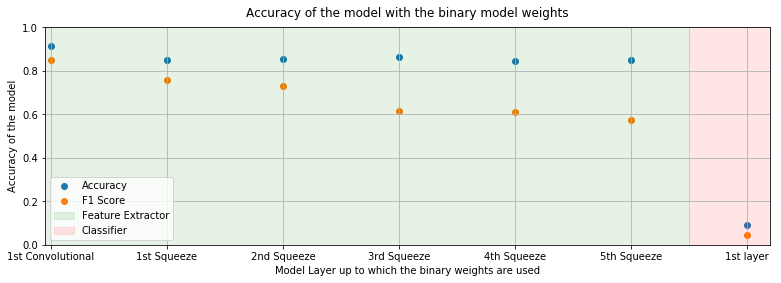

In [129]:
reg = LinearRegression()
reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(accs).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.figure(figsize=(13, 4))
plt.scatter(np.arange(0, 7), accs, label='Accuracy'.format(reg.coef_[0]))
#plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)

reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(f1s).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.scatter(np.arange(0, 7), f1s, label='F1 Score'.format(reg.coef_[0]))
#plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)
plt.fill_between([-0.05, 5.5], -1, 2, color='green', alpha=.1, label='Feature Extractor')
plt.fill_between([5.5, 6.2], -1, 2, color='r', alpha=.1, label='Classifier')

plt.xlim([-0.05, 6.2])
plt.ylim([0.0, 1])
plt.grid()
plt.xticks([i for i in range(7)], ['1st Convolutional', '1st Squeeze', '2nd Squeeze', '3rd Squeeze', 
           '4th Squeeze', '5th Squeeze', '1st layer'], rotation = 0)
plt.ylabel('Accuracy of the model')
plt.xlabel('Model Layer up to which the binary weights are used')
plt.legend(loc='lower left')
plt.title('Accuracy of the model with the binary model weights', y=1.02)
plt.show()